https://github.com/keras-team/keras/blob/2.1.1/examples/variational_autoencoder.py

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.initializers import RandomNormal
from keras_commons import get_config_proto, set_session_config, CustomTensorBoardCallback

print("TF version = ", tf.VERSION)
print("Keras version = ",keras.__version__)
set_session_config(get_config_proto())

TF version =  1.11.0
Keras version =  2.1.6-tf


In [2]:
# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Turn ints to floats and Normalize values to <0,1>
x_train = x_train/255.0
x_test = x_test/255.0

print('x_train.shape', x_train.shape)
print('y_train.shape={} y_train[:5]={}'.format(y_train.shape, y_train[:5]))

x_train.shape (60000, 28, 28)
y_train.shape=(60000,) y_train[:5]=[5 0 4 1 9]


In [3]:
HIDDEN_DIM_1 = 64
HIDDEN_DIM_2 = 32
LATENT_DIM = 16
IMG_SHAPE = (28, 28)
NOISE_RATIO = 0.1
LEARNING_RATE = 0.002
BETA = 0.1

def build_encoder():
    input_img = layers.Input(shape=IMG_SHAPE, name='encoder_input')
    x = input_img
    #x = layers.GaussianNoise(stddev=NOISE_RATIO, name='noisy_input')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(HIDDEN_DIM_1, activation=keras.activations.relu, name='fc_1')(x)
    x = layers.Dense(HIDDEN_DIM_2, activation=keras.activations.relu, name='fc_2')(x)
    latent_repr = layers.Dense(LATENT_DIM, activation=keras.activations.relu, name='latent_repr')(x)
    return Model(input_img, latent_repr, name='encoder')

def build_mu_log_var():
    latent_repr = layers.Input(shape=(LATENT_DIM, ), name='latent_repr_input')
    mu = layers.Dense(LATENT_DIM, name='mu')(latent_repr) #kernel_initializer=RandomNormal(stddev=0.001)
    log_var = layers.Dense(LATENT_DIM, name='log_var')(latent_repr)
    #var = layers.Lambda(lambda input_t: K.exp(0.5 * input_t))(log_var)
    return Model(latent_repr, [mu, log_var])

def build_sampling_model():
    def sample(mu_log_var):
        """ 
        mu_log_var = [mu, log_var]
        log_var = log(sigma**2)
        Returns a sampled tensor from the normal distribution N(mu, sigma)
        """
        mu, log_var = mu_log_var
        log_var_exp = K.exp(log_var / 2.0)
        sampled_repr = mu + log_var_exp*K.random_normal(shape=K.shape(log_var_exp), mean=0.0, stddev=1.0)
        return sampled_repr
    
    mu = layers.Input(shape=(LATENT_DIM, ), name='mu_input')
    log_var = layers.Input(shape=(LATENT_DIM, ), name='log_var_input')
    sampling_layer = layers.Lambda(sample)
    sampled_repr = sampling_layer([mu, log_var])
    return Model([mu, log_var], sampled_repr) # returning a model so I can call .predict() on it later

def build_decoder():
    latent_repr = layers.Input(shape=(LATENT_DIM, ), name='latent_repr_input')
    x = layers.Dense(HIDDEN_DIM_2, activation=keras.activations.relu, name='fc_1')(latent_repr)
    x = layers.Dense(HIDDEN_DIM_1, activation=keras.activations.relu, name='fc_2')(x)
    x = layers.Dense(np.prod(IMG_SHAPE), activation=keras.activations.relu, name='fc_3')(x)
    output_img = layers.Reshape(IMG_SHAPE)(x)
    return Model(latent_repr, output_img, name='decoder')

In [4]:
encoder = build_encoder()
decoder = build_decoder()
mu_log_var_model = build_mu_log_var()
sampling_model = build_sampling_model()

input_img = layers.Input(shape=IMG_SHAPE, name='input_img')
latent_repr = encoder(input_img)
mu, log_var = mu_log_var_model(latent_repr)
sampled_latent_repr = sampling_model([mu, log_var])
output_img = decoder(sampled_latent_repr)

autoencoder = Model(input_img, output_img, name='autoencoder')

def get_kl_loss(mu, log_var):
    def kl_loss(y_true, y_pred):
        return -0.5*K.mean(1 + log_var - K.square(mu) - K.exp(log_var))
    return kl_loss

def reconstruction_loss(y_true, y_pred):
    return keras.losses.binary_crossentropy(y_true, y_pred)

def total_loss(y_true, y_pred):
    rec_loss = reconstruction_loss(y_true, y_pred)
    kl = get_kl_loss(mu, log_var)(y_true, y_pred)
    return rec_loss + BETA * kl

autoencoder.compile(loss=[total_loss], metrics=[reconstruction_loss, get_kl_loss(mu, log_var)], 
                    optimizer=keras.optimizers.RMSprop())

### Train the VAE

Sometimes it just fails to learn anything and collapses to 0 KL divergence = needs tuning of BETA, losses, latent_dim

In [5]:
TB_callback = CustomTensorBoardCallback(log_dir='./tf_logs', write_graph=True, update_freq='epoch')

history = autoencoder.fit(x_train, x_train,
              batch_size=128,
              epochs=15,
              verbose=2,
              validation_data=(x_test, x_test),
              callbacks=[TB_callback])

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
 - 4s - loss: 0.3216 - reconstruction_loss: 0.3147 - kl_loss: 0.0691 - val_loss: 0.2921 - val_reconstruction_loss: 0.2789 - val_kl_loss: 0.1322
Epoch 2/15
 - 3s - loss: 0.2889 - reconstruction_loss: 0.2718 - kl_loss: 0.1709 - val_loss: 0.2836 - val_reconstruction_loss: 0.2636 - val_kl_loss: 0.2000
Epoch 3/15
 - 3s - loss: 0.2828 - reconstruction_loss: 0.2623 - kl_loss: 0.2046 - val_loss: 0.2779 - val_reconstruction_loss: 0.2546 - val_kl_loss: 0.2328
Epoch 4/15
 - 3s - loss: 0.2780 - reconstruction_loss: 0.2555 - kl_loss: 0.2255 - val_loss: 0.2742 - val_reconstruction_loss: 0.2508 - val_kl_loss: 0.2336
Epoch 5/15
 - 3s - loss: 0.2760 - reconstruction_loss: 0.2528 - kl_loss: 0.2321 - val_loss: 0.2717 - val_reconstruction_loss: 0.2481 - val_kl_loss: 0.2366
Epoch 6/15
 - 3s - loss: 0.2744 - reconstruction_loss: 0.2507 - kl_loss: 0.2374 - val_loss: 0.2718 - val_reconstruction_loss: 0.2484 - val_kl_loss: 0.2340
Epoch 7/15
 - 3s - l

In [6]:
num_pred = 16

# equivalent to predicted_imgs = autoencoder.predict(x_test[:num_pred]) 
latent_reprs = encoder.predict(x_test[:num_pred])
mus, log_vars = mu_log_var_model.predict(latent_reprs)
sampled_latent_reprs = sampling_model.predict([mus, log_vars])
predicted_imgs = decoder.predict(sampled_latent_reprs)

In [7]:
latent_reprs[7]

array([0.        , 0.50983226, 1.5901856 , 0.        , 0.        ,
       0.14029723, 0.1314072 , 1.5952971 , 0.39339286, 0.0873443 ,
       0.1300237 , 0.        , 0.53269625, 0.        , 0.42714423,
       0.        ], dtype=float32)

In [8]:
mus[7]

array([-0.07000491,  0.67078775, -0.3383637 , -0.00276756, -0.05830926,
        0.05295124, -0.0335152 ,  0.05234498,  0.8297816 ,  0.0061777 ,
       -0.01516721, -0.04400246,  0.06300022,  0.23145385, -0.13699149,
       -0.03777112], dtype=float32)

In [9]:
np.exp(log_vars[7])

array([0.98607975, 0.34241658, 0.06892203, 0.9670805 , 0.9249605 ,
       0.9386259 , 0.9906203 , 0.94775516, 0.13678405, 0.98770463,
       0.9771924 , 0.9552676 , 0.93187344, 0.1273442 , 0.9178532 ,
       0.96932316], dtype=float32)

Original Images


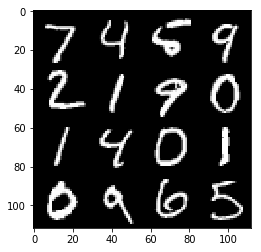

Reconstructed Images


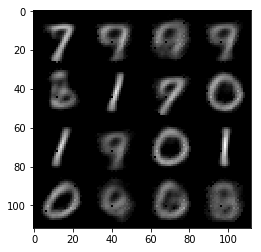

In [18]:
def plot_predicted_imgs(orig_imgs, predicted_imgs):
    n = int(np.ceil(np.sqrt(num_pred)))
    canvas_orig = []
    canvas_recon = []
    canvas_noisy = []
    for i in range(n):
        # Display original images
        canvas_orig.append(np.concatenate((orig_imgs[i*4:(i+1)*4])))
        # Display reconstructed images
        canvas_recon.append(np.concatenate((predicted_imgs[i*4:(i+1)*4])))

    print("Original Images")
    plt.figure(figsize=(n, n))
    plt.imshow(np.concatenate(canvas_orig, axis=1), origin="upper", cmap="gray")
    plt.show()

    print("Reconstructed Images")
    plt.figure(figsize=(n, n))
    plt.imshow(np.concatenate(canvas_recon, axis=1), origin="upper", cmap="gray")
    plt.show()

plot_predicted_imgs(x_test, predicted_imgs)

### Sample from one mu, variance

In [24]:
def sample_from_one_latent_repr(idx, num_pred):
    orig_imgs = [x_test[idx] for x in range(num_pred)]
    means = [mus[idx] for x in range(num_pred)]
    logs = [log_vars[idx] for x in range(num_pred)]
    
    sampled_latent_reprs = sampling_model.predict([means, logs])
    predicted_imgs = decoder.predict(sampled_latent_reprs)
    
    plot_predicted_imgs(orig_imgs, predicted_imgs)

Original Images


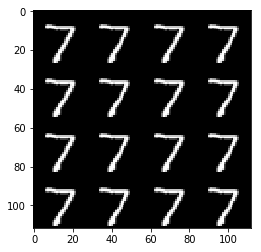

Reconstructed Images


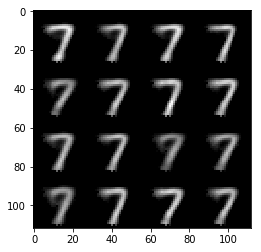

Original Images


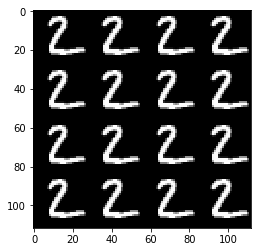

Reconstructed Images


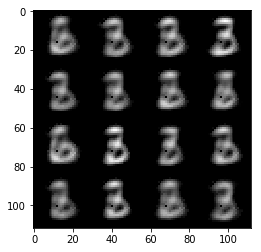

Original Images


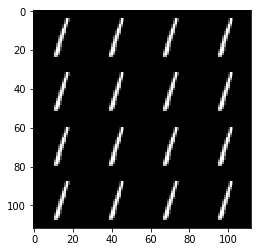

Reconstructed Images


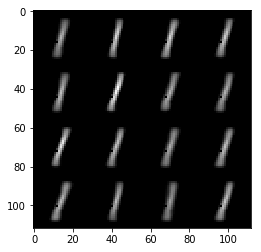

In [28]:
sample_from_one_latent_repr(0, num_pred)
sample_from_one_latent_repr(1, num_pred)
sample_from_one_latent_repr(2, num_pred)